# Initiate Settings

In [11]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- n(z) and binning utility ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)

def make_bins(nz_func, z, nbins):
    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

# --- Survey and cosmology settings ---
z = np.linspace(0.001, 3.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)


def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)  # Include ell_max
    log_ell_mean = np.mean(np.log(ells))    # Uniform weights
    ell_eff = np.exp(log_ell_mean)
    return ell_eff

ell_min = 100
ell_max = 1000

ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
print(f"Effective multipole (uniform weighting) for band [{ell_min}, {ell_max}]: {ell_eff:.2f}")

area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.] * 10

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}


Effective multipole (uniform weighting) for band [100, 1000]: 474.92


# Build the class

In [12]:
import numpy as np
import pyccl as ccl
import PySSC

class Forecast3x2pt:
    def __init__(self,
                 nz_lens,
                 nz_src,
                 ell,
                 area_deg2,
                 n_eff,
                 sigma_eps,
                 bias_lens,
                 fid_cosmo):
        """
        Initialize the forecast object for a 3x2pt analysis.

        Parameters
        ----------
        nz_lens : list of (z, n(z)) tuples
            Redshift distributions for lens bins.
        nz_src : list of (z, n(z)) tuples
            Redshift distributions for source bins.
        ell : array_like
            Multipole bin centers.
        area_deg2 : float
            Survey area in square degrees.
        n_eff : float
            Effective galaxy number density per arcmin^2 for source galaxies.
        sigma_eps : float
            Shape noise per component.
        bias_lens : list of floats
            Linear galaxy bias for each lens bin.
        fid_cosmo : dict
            Fiducial cosmological parameters.
        """
        self.nz_lens = nz_lens
        self.nz_src = nz_src
        self.ell = np.array(ell)
        self.area_deg2 = area_deg2
        self.n_eff = n_eff
        self.sigma_eps = sigma_eps
        self.bias_lens = np.array(bias_lens)
        self.fid_cosmo = fid_cosmo

        self._init_cosmology()

    def _init_cosmology(self):
        """
        Set up pyccl cosmology object.
        """
        self.cosmo = ccl.Cosmology(
            Omega_c=self.fid_cosmo["Omega_m"] - self.fid_cosmo["Omega_b"],
            Omega_b=self.fid_cosmo["Omega_b"],
            h=self.fid_cosmo["h"],
            sigma8=self.fid_cosmo["sigma_8"],
            n_s=self.fid_cosmo["n_s"],
            w0=self.fid_cosmo["w0"],
            wa=self.fid_cosmo["wa"],
            extra_parameters={'camb': {'dark_energy_model': 'ppf'}}
        )

    def plot_nz_bins(self):
        """
        Plot the normalized redshift distributions for lens and source bins.
        """
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        colors = plt.cm.viridis(np.linspace(0, 1, max(len(self.nz_lens), len(self.nz_src))))

        # Lens bins
        for i, (z, nz) in enumerate(self.nz_lens):
            axes[0].plot(z, nz, label=f'Lens bin {i+1}', color=colors[i])
        axes[0].set_title("Lens Bins")
        axes[0].set_xlabel("z")
        axes[0].set_ylabel("n(z)")
        axes[0].legend()

        # Source bins
        for i, (z, nz) in enumerate(self.nz_src):
            axes[1].plot(z, nz, label=f'Source bin {i+1}', color=colors[i])
        axes[1].set_title("Source Bins")
        axes[1].set_xlabel("z")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def compute_cls(self):
        """
        Compute angular power spectra for galaxy clustering (gg),
        galaxy-galaxy lensing (gk), and cosmic shear (kk) using pyccl.
        
        Returns
        -------
        cl_dict : dict
            Dictionary with keys 'gg', 'gk', 'kk', each a 3D array:
            [n_lens, n_lens/source, n_ell]
        """
        n_lens = len(self.nz_lens)
        n_src = len(self.nz_src)
        ell = self.ell

        # Tracers
        lens_tracers = []
        for i, (z, nz) in enumerate(self.nz_lens):
            bias = self.bias_lens[i]
            lens_tracers.append(
                ccl.NumberCountsTracer(
                    self.cosmo,
                    has_rsd=False,
                    dndz=(z, nz),
                    bias=(z, bias * np.ones_like(z))
                )
            )

        src_tracers = [
            ccl.WeakLensingTracer(self.cosmo, dndz=(z, nz))
            for (z, nz) in self.nz_src
        ]

        # Initialize power spectra containers
        cl_gg = np.zeros((n_lens, n_lens, len(ell)))
        cl_gk = np.zeros((n_lens, n_src, len(ell)))
        cl_kk = np.zeros((n_src, n_src, len(ell)))

        # Compute Cls
        for i in range(n_lens):
            for j in range(i, n_lens):
                cl = ccl.angular_cl(self.cosmo, lens_tracers[i], lens_tracers[j], ell)
                cl_gg[i, j] = cl
                cl_gg[j, i] = cl  # symmetry

        for i in range(n_lens):
            for j in range(n_src):
                cl = ccl.angular_cl(self.cosmo, lens_tracers[i], src_tracers[j], ell)
                cl_gk[i, j] = cl

        for i in range(n_src):
            for j in range(i, n_src):
                cl = ccl.angular_cl(self.cosmo, src_tracers[i], src_tracers[j], ell)
                cl_kk[i, j] = cl
                cl_kk[j, i] = cl  # symmetry

        return {"gg": cl_gg, "gk": cl_gk, "kk": cl_kk}

    def extract_gk_vector(self, cl_dict):
        """
        Extract vector of C_ell^{g_i kappa_j} where j > i.

        Parameters
        ----------
        cl_dict : dict
            Output from compute_cls(), with key 'gk' as [n_lens, n_src, n_ell].

        Returns
        -------
        gk_vector : np.ndarray
            1D array of all gk Cls with j > i (lens i, source j).
        labels : list of str
            Labels corresponding to each element, e.g. 'g1k2'.
        """
        cl_gk = cl_dict["gk"]
        n_lens, n_src, n_ell = cl_gk.shape

        gk_vector = []
        labels = []

        for i in range(n_lens):
            for j in range(n_src):
                if j > i:
                    gk_vector.append(cl_gk[i, j])
                    labels.append(f"g{i+1}k{j+1}")

        gk_vector = np.array(gk_vector)  # shape: (N_valid, n_ell)

        return gk_vector, labels



    
    def compute_gk_covariance_matrix(self, cl_dict, ell, delta_ell):
        """
        Compute the Gaussian covariance matrix for the gk_vector
        (C_ell^{g_i kappa_j} with j > i), including shot noise.

        Parameters
        ----------
        cl_dict : dict
            Dictionary from compute_cls() containing 'gg', 'gk', 'kk'.
        ell : float
            Effective ell of the bandpower.
        delta_ell : int
            Width of the ell bin.

        Returns
        -------
        cov : np.ndarray
            Covariance matrix for gk_vector.
        labels : list of str
            Corresponding labels for the gk_vector entries.
        """
        cl_gg = cl_dict["gg"]
        cl_gk = cl_dict["gk"]
        cl_kk = cl_dict["kk"]
        n_lens = len(self.nz_lens)
        n_src = len(self.nz_src)

        # Build index list of valid gk combinations (j > i)
        indices = []
        labels = []
        for i in range(n_lens):
            for j in range(n_src):
                if j > i:
                    indices.append((i, j))
                    labels.append(f"g{i+1}k{j+1}")

        N = len(indices)

        # Precompute noise terms
        steradian_conversion = 3600 * (180 / np.pi)**2
        nbar_lens = self.n_eff * steradian_conversion / n_lens
        nbar_src = self.n_eff * steradian_conversion / n_src
        sigma_e_sq = self.sigma_eps ** 2

        f_sky = self.area_deg2 / 41253.
        prefac = 1 / ((2 * ell + 1) * f_sky * delta_ell)

        cov = np.zeros((N, N))

        for a, (i, j) in enumerate(indices):
            for b, (k, l) in enumerate(indices):
                # C_l^{g_i g_k}
                C_gg = cl_gg[i, k, 0]
                if i == k:
                    C_gg += 1.0 / nbar_lens

                # C_l^{kappa_j kappa_l}
                C_kk = cl_kk[j, l, 0]
                if j == l:
                    C_kk += sigma_e_sq / nbar_src

                # C_l^{g_i kappa_l}
                C_gl = cl_gk[i, l, 0]  # no noise

                # C_l^{g_k kappa_j}
                C_kj = cl_gk[k, j, 0]  # no noise

                cov[a, b] = prefac * (C_gg * C_kk + C_gl * C_kj)

        return cov, labels

    def compute_shear_ratios(self, gk_vector, gk_labels):
        """
        Compute shear ratio data vector R_ij = C^{g_i κ_j} / C^{g_i κ_k}
        for fixed g_i and all j > i, k > j.
    
        Parameters
        ----------
        gk_vector : np.ndarray
            Array of C_l^{g_i kappa_j} values, shape (n_valid, n_ell).
        gk_labels : list of str
            Labels like 'g1k2', 'g1k3', etc., where k > g.
    
        Returns
        -------
        R : np.ndarray
            Shear ratio vector.
        ratio_labels : list of tuple
            Triplet (i, j, k) corresponding to R_ij/R_ik.
        """
        import re
        from itertools import combinations
    
        # Parse (i, j) pairs
        pairs = []
        for label in gk_labels:
            i, j = map(int, re.findall(r'\d+', label))
            pairs.append((i - 1, j - 1))  # zero-based
    
        # Map from (i, j) to index in gk_vector
        pair_to_index = {pair: idx for idx, pair in enumerate(pairs)}
    
        # Build shear ratios
        R = []
        ratio_labels = []
        for i in range(self.nz_lens.__len__()):
            valid_js = [j for (ii, j) in pairs if ii == i and j > i]
            for j, k in combinations(valid_js, 2):
                num = gk_vector[pair_to_index[(i, j)]]
                den = gk_vector[pair_to_index[(i, k)]]
                R.append(num / den)
                ratio_labels.append((i + 1, j + 1, k + 1))  # 1-based for readability
    
        R = np.array(R)  # shape (n_ratios, n_ell)
        return R, ratio_labels

    def compute_gk_covariance_matrix(self, cl_dict, ell, delta_ell)

    def sample_gk_vector(self, gk_vector, gk_cov, nsamples=20000, seed=None):
        """
        Draw Monte Carlo realisations of the gk_vector from its covariance.
    
        Parameters
        ----------
        gk_vector : np.ndarray
            Mean vector of C_l^{g_i kappa_j} values (shape: [n, n_ell]).
        gk_cov : np.ndarray
            Covariance matrix of the gk_vector (shape: [n, n]).
        nsamples : int
            Number of Monte Carlo samples to generate.
        seed : int or None
            Random seed for reproducibility.
    
        Returns
        -------
        samples : np.ndarray
            Noisy samples of gk_vector (shape: [nsamples, n, n_ell]).
        """
        rng = np.random.default_rng(seed)
        n, n_ell = gk_vector.shape
        mean = gk_vector[:, 0]  # assuming all ell bins are the same (or just 1 bin)
        samples = rng.multivariate_normal(mean, gk_cov, size=nsamples)
        samples = samples[..., np.newaxis] * np.ones((1, 1, n_ell))  # expand to match original shape
        return samples

    def monte_carlo_shear_ratio_cov(self, gk_vector, gk_cov, gk_labels, nsamples=20000, seed=None):
        """
        Compute the covariance of the shear ratio data vector using MC sampling.
    
        Parameters
        ----------
        gk_vector : np.ndarray
            Mean gk vector, shape (n_valid, n_ell).
        gk_cov : np.ndarray
            Covariance matrix of gk vector, shape (n_valid, n_valid).
        gk_labels : list of str
            Labels for the gk vector elements.
        nsamples : int
            Number of Monte Carlo samples.
        seed : int or None
            Random seed for reproducibility.
    
        Returns
        -------
        R_cov : np.ndarray
            Covariance matrix of the shear-ratio vector, shape (n_ratio, n_ratio).
        R_mean : np.ndarray
            Mean shear-ratio vector, shape (n_ratio,).
        ratio_labels : list of tuple
            List of (i, j, k) labels for each ratio.
        """
        samples = self.sample_gk_vector(gk_vector, gk_cov, nsamples=nsamples, seed=seed)
        n_ell = gk_vector.shape[1]
    
        R_samples = []
        for s in range(nsamples):
            R, labels = self.compute_shear_ratios(samples[s], gk_labels)
            R_samples.append(R[:, 0])  # assuming single ell bin
    
        R_samples = np.array(R_samples)  # (nsamples, n_ratios)
        R_mean = np.mean(R_samples, axis=0)
        R_cov = np.cov(R_samples, rowvar=False)
    
        return R_cov, R_mean, labels

    def compute_shear_ratio_derivatives(self, cl_dict, gk_labels, param_dict, step_frac=0.05):
        """
        Compute numerical derivatives of the shear-ratio data vector w.r.t. cosmological parameters.
    
        Parameters
        ----------
        cl_dict : dict
            Fiducial Cl dictionary from compute_cls().
        gk_labels : list of str
            Labels for the gk_vector elements.
        param_dict : dict
            Parameters to vary and their fiducial values.
        step_frac : float
            Fractional step size for derivative.
    
        Returns
        -------
        derivs : dict
            Dictionary of derivatives: param_name -> dR/dparam (shape: [n_data,])
        R_fid : np.ndarray
            Fiducial shear ratio vector.
        ratio_labels : list of tuple
            Labels for each ratio.
        """
        derivs = {}
        gk_vector_fid, _ = self.extract_gk_vector(cl_dict)
        R_fid, ratio_labels = self.compute_shear_ratios(gk_vector_fid, gk_labels)
    
        fid_copy = self.fid_cosmo.copy()
    
        for p, val in param_dict.items():
            dval = val * step_frac
    
            # Perturb +
            self.fid_cosmo = fid_copy.copy()
            self.fid_cosmo[p] = val + dval
            self._init_cosmology()
            cl_plus = self.compute_cls()
            gk_plus, _ = self.extract_gk_vector(cl_plus)
            R_plus, _ = self.compute_shear_ratios(gk_plus, gk_labels)
    
            # Perturb -
            self.fid_cosmo = fid_copy.copy()
            self.fid_cosmo[p] = val - dval
            self._init_cosmology()
            cl_minus = self.compute_cls()
            gk_minus, _ = self.extract_gk_vector(cl_minus)
            R_minus, _ = self.compute_shear_ratios(gk_minus, gk_labels)
    
            # Central difference
            derivs[p] = (R_plus[:, 0] - R_minus[:, 0]) / (2 * dval)
    
        # Restore fiducial cosmology
        self.fid_cosmo = fid_copy.copy()
        self._init_cosmology()
    
        return derivs, R_fid[:, 0], ratio_labels

    def compute_shear_ratio_fisher(self, R_cov, derivs):
        """
        Compute Fisher matrix from shear ratio derivatives and covariance.
    
        Parameters
        ----------
        R_cov : np.ndarray
            Covariance of the shear-ratio data vector.
        derivs : dict
            Dictionary of derivatives: param_name -> dR/dparam.
    
        Returns
        -------
        fisher : np.ndarray
            Fisher matrix, shape (n_params, n_params).
        param_list : list
            Parameter names, in order.
        """
        from numpy.linalg import inv
    
        inv_cov = inv(R_cov)
        param_list = list(derivs.keys())
        n_params = len(param_list)
    
        fisher = np.zeros((n_params, n_params))
        for i, pi in enumerate(param_list):
            for j, pj in enumerate(param_list):
                dRi = derivs[pi]
                dRj = derivs[pj]
                fisher[i, j] = dRi @ inv_cov @ dRj
    
        return fisher, param_list

    def plot_fisher_ellipses(self, fisher, param_list, truths=None):
        """
        Plot 2D confidence ellipses (68% and 95%) using Fisher matrix with matplotlib.
    
        Parameters
        ----------
        fisher : np.ndarray
            Fisher matrix.
        param_list : list of str
            Parameter names.
        truths : dict or None
            Fiducial parameter values.
        """
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib.patches import Ellipse
    
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
            "axes.labelsize": 16,
            "font.size": 16,
            "xtick.labelsize": 14,
            "ytick.labelsize": 14,
            "legend.fontsize": 14,
        })
    
        label_map = {
            "Omega_m": r"$\Omega_m$",
            "Omega_b": r"$\Omega_b$",
            "sigma_8": r"$\sigma_8$",
            "n_s": r"$n_s$",
            "h": r"$h$",
            "w0": r"$w_0$",
            "wa": r"$w_a$"
        }
    
        cov = np.linalg.inv(fisher)
        n_params = len(param_list)
        mean = np.array([truths[p] if truths else 0 for p in param_list])
        stds = np.sqrt(np.diag(cov))
    
        fig_width = np.sum(6 * stds)
        fig_height = np.sum(6 * stds)
        fig, axes = plt.subplots(n_params, n_params, figsize=(fig_width, fig_height), squeeze=False)
        plt.subplots_adjust(wspace=0, hspace=0)
    
        chi2_vals = [2.30, 5.99]  # 68% and 95% confidence for 2D Gaussian
    
        for i in range(n_params):
            for j in range(n_params):
                ax = axes[i, j]
    
                if j > i:
                    ax.axis('off')
                    continue
                elif i == j:
                    sigma = stds[i]
                    x = np.linspace(mean[i] - 3*sigma, mean[i] + 3*sigma, 300)
                    y = np.exp(-0.5*((x - mean[i])/sigma)**2)
                    ax.plot(x, y, color='black')
                    ax.axvline(mean[i], color='black')
                    ax.set_yticks([])
                    ax.set_xlim(mean[i] - 3*sigma, mean[i] + 3*sigma)
                else:
                    sub_cov = cov[[j, i]][:, [j, i]]
                    vals, vecs = np.linalg.eigh(sub_cov)
                    angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
    
                    for chi2_val, lw in zip(chi2_vals, [1.5, 1]):
                        width, height = 2 * np.sqrt(chi2_val) * np.sqrt(vals)
                        ellipse = Ellipse(xy=(mean[j], mean[i]), width=width, height=height,
                                          angle=angle, edgecolor='black', facecolor='none', linewidth=lw)
                        ax.add_patch(ellipse)
    
                    ax.axvline(mean[j], color='gray')
                    ax.axhline(mean[i], color='gray')
                    ax.set_xlim(mean[j] - 3*stds[j], mean[j] + 3*stds[j])
                    ax.set_ylim(mean[i] - 3*stds[i], mean[i] + 3*stds[i])
    
                if i == n_params - 1:
                    ax.set_xlabel(label_map.get(param_list[j], f"${param_list[j]}$"))
                else:
                    ax.set_xticks([])
                if j == 0:
                    ax.set_ylabel(label_map.get(param_list[i], f"${param_list[i]}$"))
                else:
                    ax.set_yticks([])
    
        plt.tight_layout(pad=0)
        plt.show()

SyntaxError: expected ':' (3440502861.py, line 299)

# initiate the class

In [ ]:
forecast = Forecast3x2pt(nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo
)



# plot the bins

In [ ]:
forecast.plot_nz_bins()

# compute power spectra

In [ ]:
cl_dict = forecast.compute_cls()

# Example access:
cl_g1g2 = cl_dict["gg"][0, 1]  # Cl for lens bins 1 and 2
cl_g1k3 = cl_dict["gk"][0, 2]  # Cl for galaxy-galaxy lensing (g1 x κ3)
cl_k2k2 = cl_dict["kk"][1, 1]  # Cl for shear-shear (κ2 x κ2)

# Just extract the gk vector

g1k2


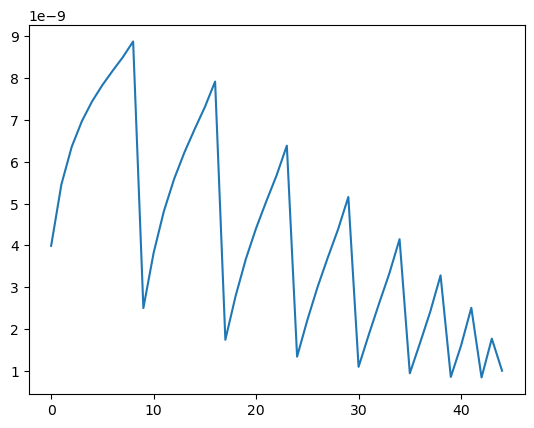

In [13]:
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)

# Inspect one element
print(gk_labels[0])       # e.g., "g1k2"
plt.plot(gk_vector)

# covariance of the gk vector

In [14]:
cl_dict = forecast.compute_cls()
ell_eff = ell_eff_uniform_weighting(100, 1000)
cov_gk, gk_labels = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=900)

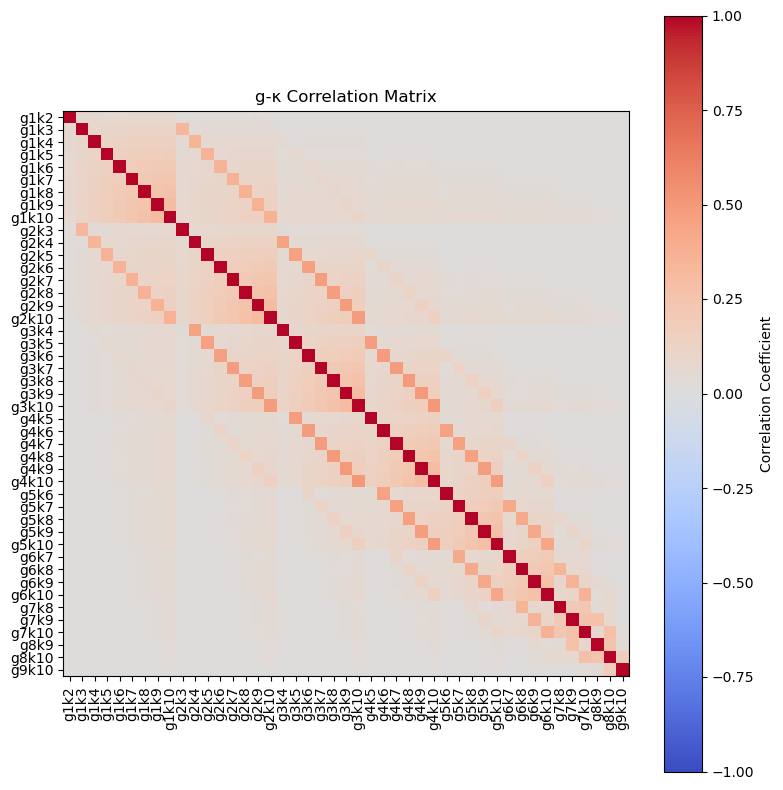

In [15]:
def plot_gk_correlation_matrix(cov_gk, gk_labels):
    import matplotlib.pyplot as plt
    import numpy as np

    corr = cov_gk / np.sqrt(np.outer(np.diag(cov_gk), np.diag(cov_gk)))

    plt.figure(figsize=(8, 8))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, label="Correlation Coefficient")

    plt.xticks(np.arange(len(gk_labels)), gk_labels, rotation=90)
    plt.yticks(np.arange(len(gk_labels)), gk_labels)
    plt.title("g-κ Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_gk_correlation_matrix(cov_gk, gk_labels)

Text(0.5, 0, 'monte carlo gk')

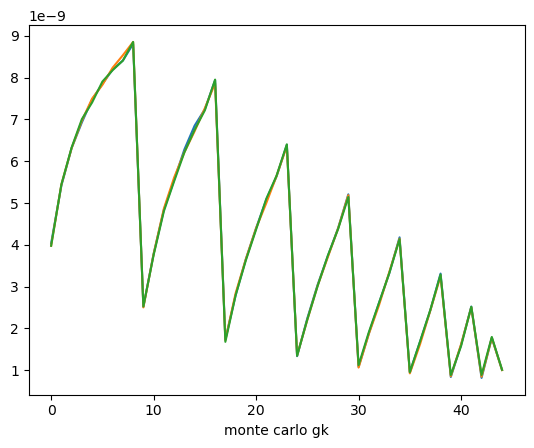

In [16]:
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=900)
samples = forecast.sample_gk_vector(gk_vector, gk_cov, nsamples=20000, seed=42)
plt.plot(samples[0])
plt.plot(samples[1])
plt.plot(samples[2])
plt.xlabel('monte carlo gk')

# Shear-Ratio Data vector

In [17]:
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
R, shear_ratio_labels = forecast.compute_shear_ratios(gk_vector, gk_labels)

Text(0.5, 0, 'shear-ratio DV')

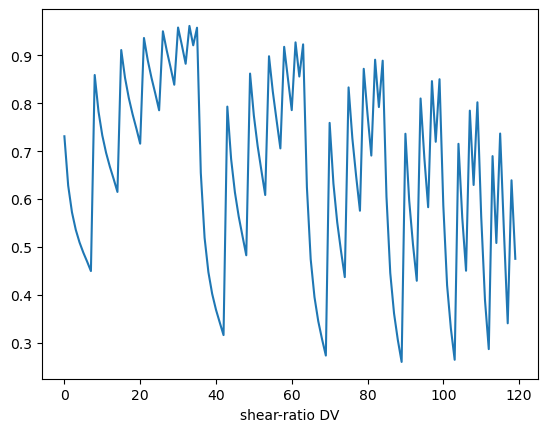

In [18]:
plt.plot(R)
plt.xlabel('shear-ratio DV')

# Shear-ratio covariance

In [19]:
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=900)
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)

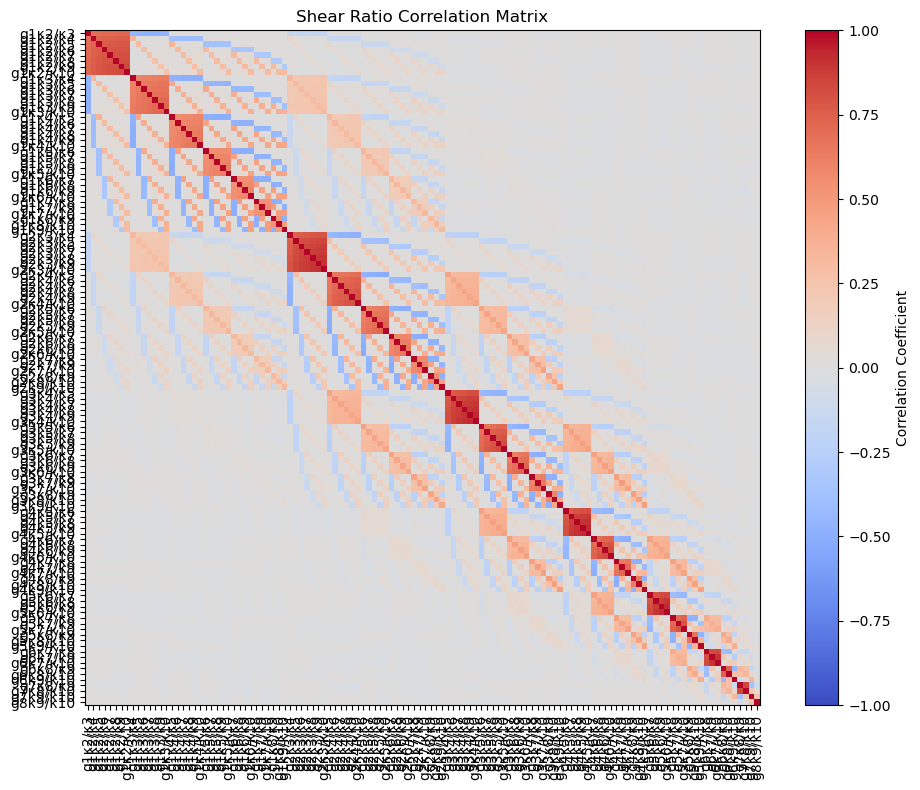

In [20]:
def plot_shear_ratio_correlation_matrix(R_cov, ratio_labels):
    import matplotlib.pyplot as plt
    import numpy as np

    corr = R_cov / np.sqrt(np.outer(np.diag(R_cov), np.diag(R_cov)))

    labels = [f"g{i}κ{j}/κ{k}" for (i, j, k) in ratio_labels]

    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, label="Correlation Coefficient")
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title("Shear Ratio Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_shear_ratio_correlation_matrix(R_cov, ratio_labels)

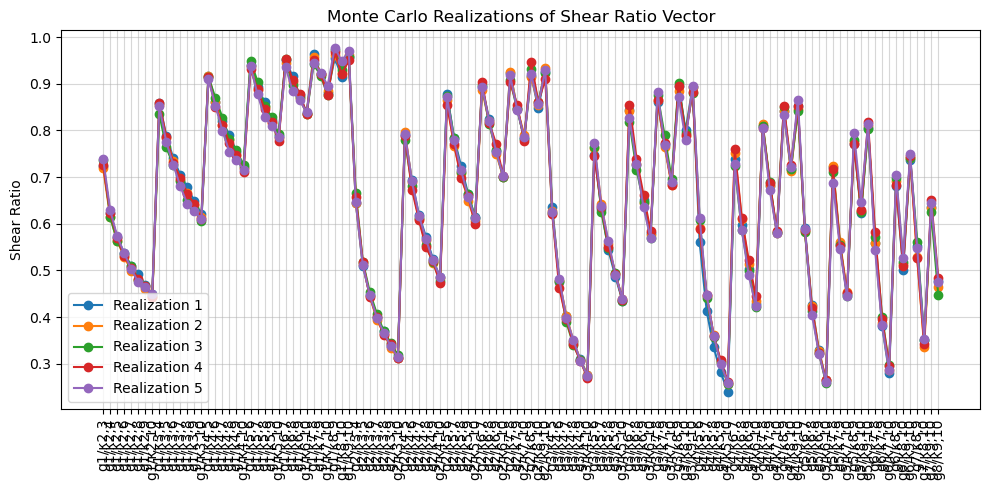

In [21]:
def plot_shear_ratio_mc_realizations(gk_vector, gk_cov, gk_labels, compute_shear_ratios_func, n_draws=5, seed=None):
    """
    Draw and plot a few MC realizations of the shear ratio data vector.

    Parameters
    ----------
    gk_vector : np.ndarray
        Mean gk vector, shape (n_valid, n_ell).
    gk_cov : np.ndarray
        Covariance matrix of gk vector, shape (n_valid, n_valid).
    gk_labels : list of str
        Labels for the gk vector elements.
    compute_shear_ratios_func : callable
        Function to compute shear ratios: (gk_vector, gk_labels) -> (R, labels)
    n_draws : int
        Number of realizations to draw.
    seed : int or None
        Random seed.
    """
    rng = np.random.default_rng(seed)
    n, n_ell = gk_vector.shape
    mean = gk_vector[:, 0]
    samples = rng.multivariate_normal(mean, gk_cov, size=n_draws)
    samples = samples[..., np.newaxis] * np.ones((1, 1, n_ell))  # expand

    all_R = []
    for i in range(n_draws):
        R, labels = compute_shear_ratios_func(samples[i], gk_labels)
        all_R.append(R[:, 0])  # assuming single ell

    all_R = np.array(all_R)
    x = np.arange(all_R.shape[1])

    plt.figure(figsize=(10, 5))
    for i in range(n_draws):
        plt.plot(x, all_R[i], label=f"Realization {i+1}", marker='o')

    xlabels = [f"g{i}/κ{j},{k}" for (i, j, k) in labels]
    plt.xticks(x, xlabels, rotation=90)
    plt.ylabel("Shear Ratio")
    plt.title("Monte Carlo Realizations of Shear Ratio Vector")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()
plot_shear_ratio_mc_realizations(
    gk_vector, gk_cov, gk_labels,
    compute_shear_ratios_func=forecast.compute_shear_ratios,
    n_draws=5, seed=1
)

# Now let's look at the Fisher

In [22]:
# Compute Cls
cl_dict = forecast.compute_cls()

# Extract gk vector and labels
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)

# Compute gk covariance
ell_eff = ell_eff_uniform_weighting(100, 1000)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=900)

# Compute shear-ratio covariance from Monte Carlo
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(
    gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42
)

# Derivatives and Fisher matrix
param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

# Print parameter errors
errors = np.sqrt(np.diag(np.linalg.inv(Fisher)))
for p, err in zip(param_list, errors):
    print(f"{p:8s} : {err:.4f}")

Omega_m  : 0.2812
h        : 0.9073
w0       : 0.7485
wa       : 3.1177


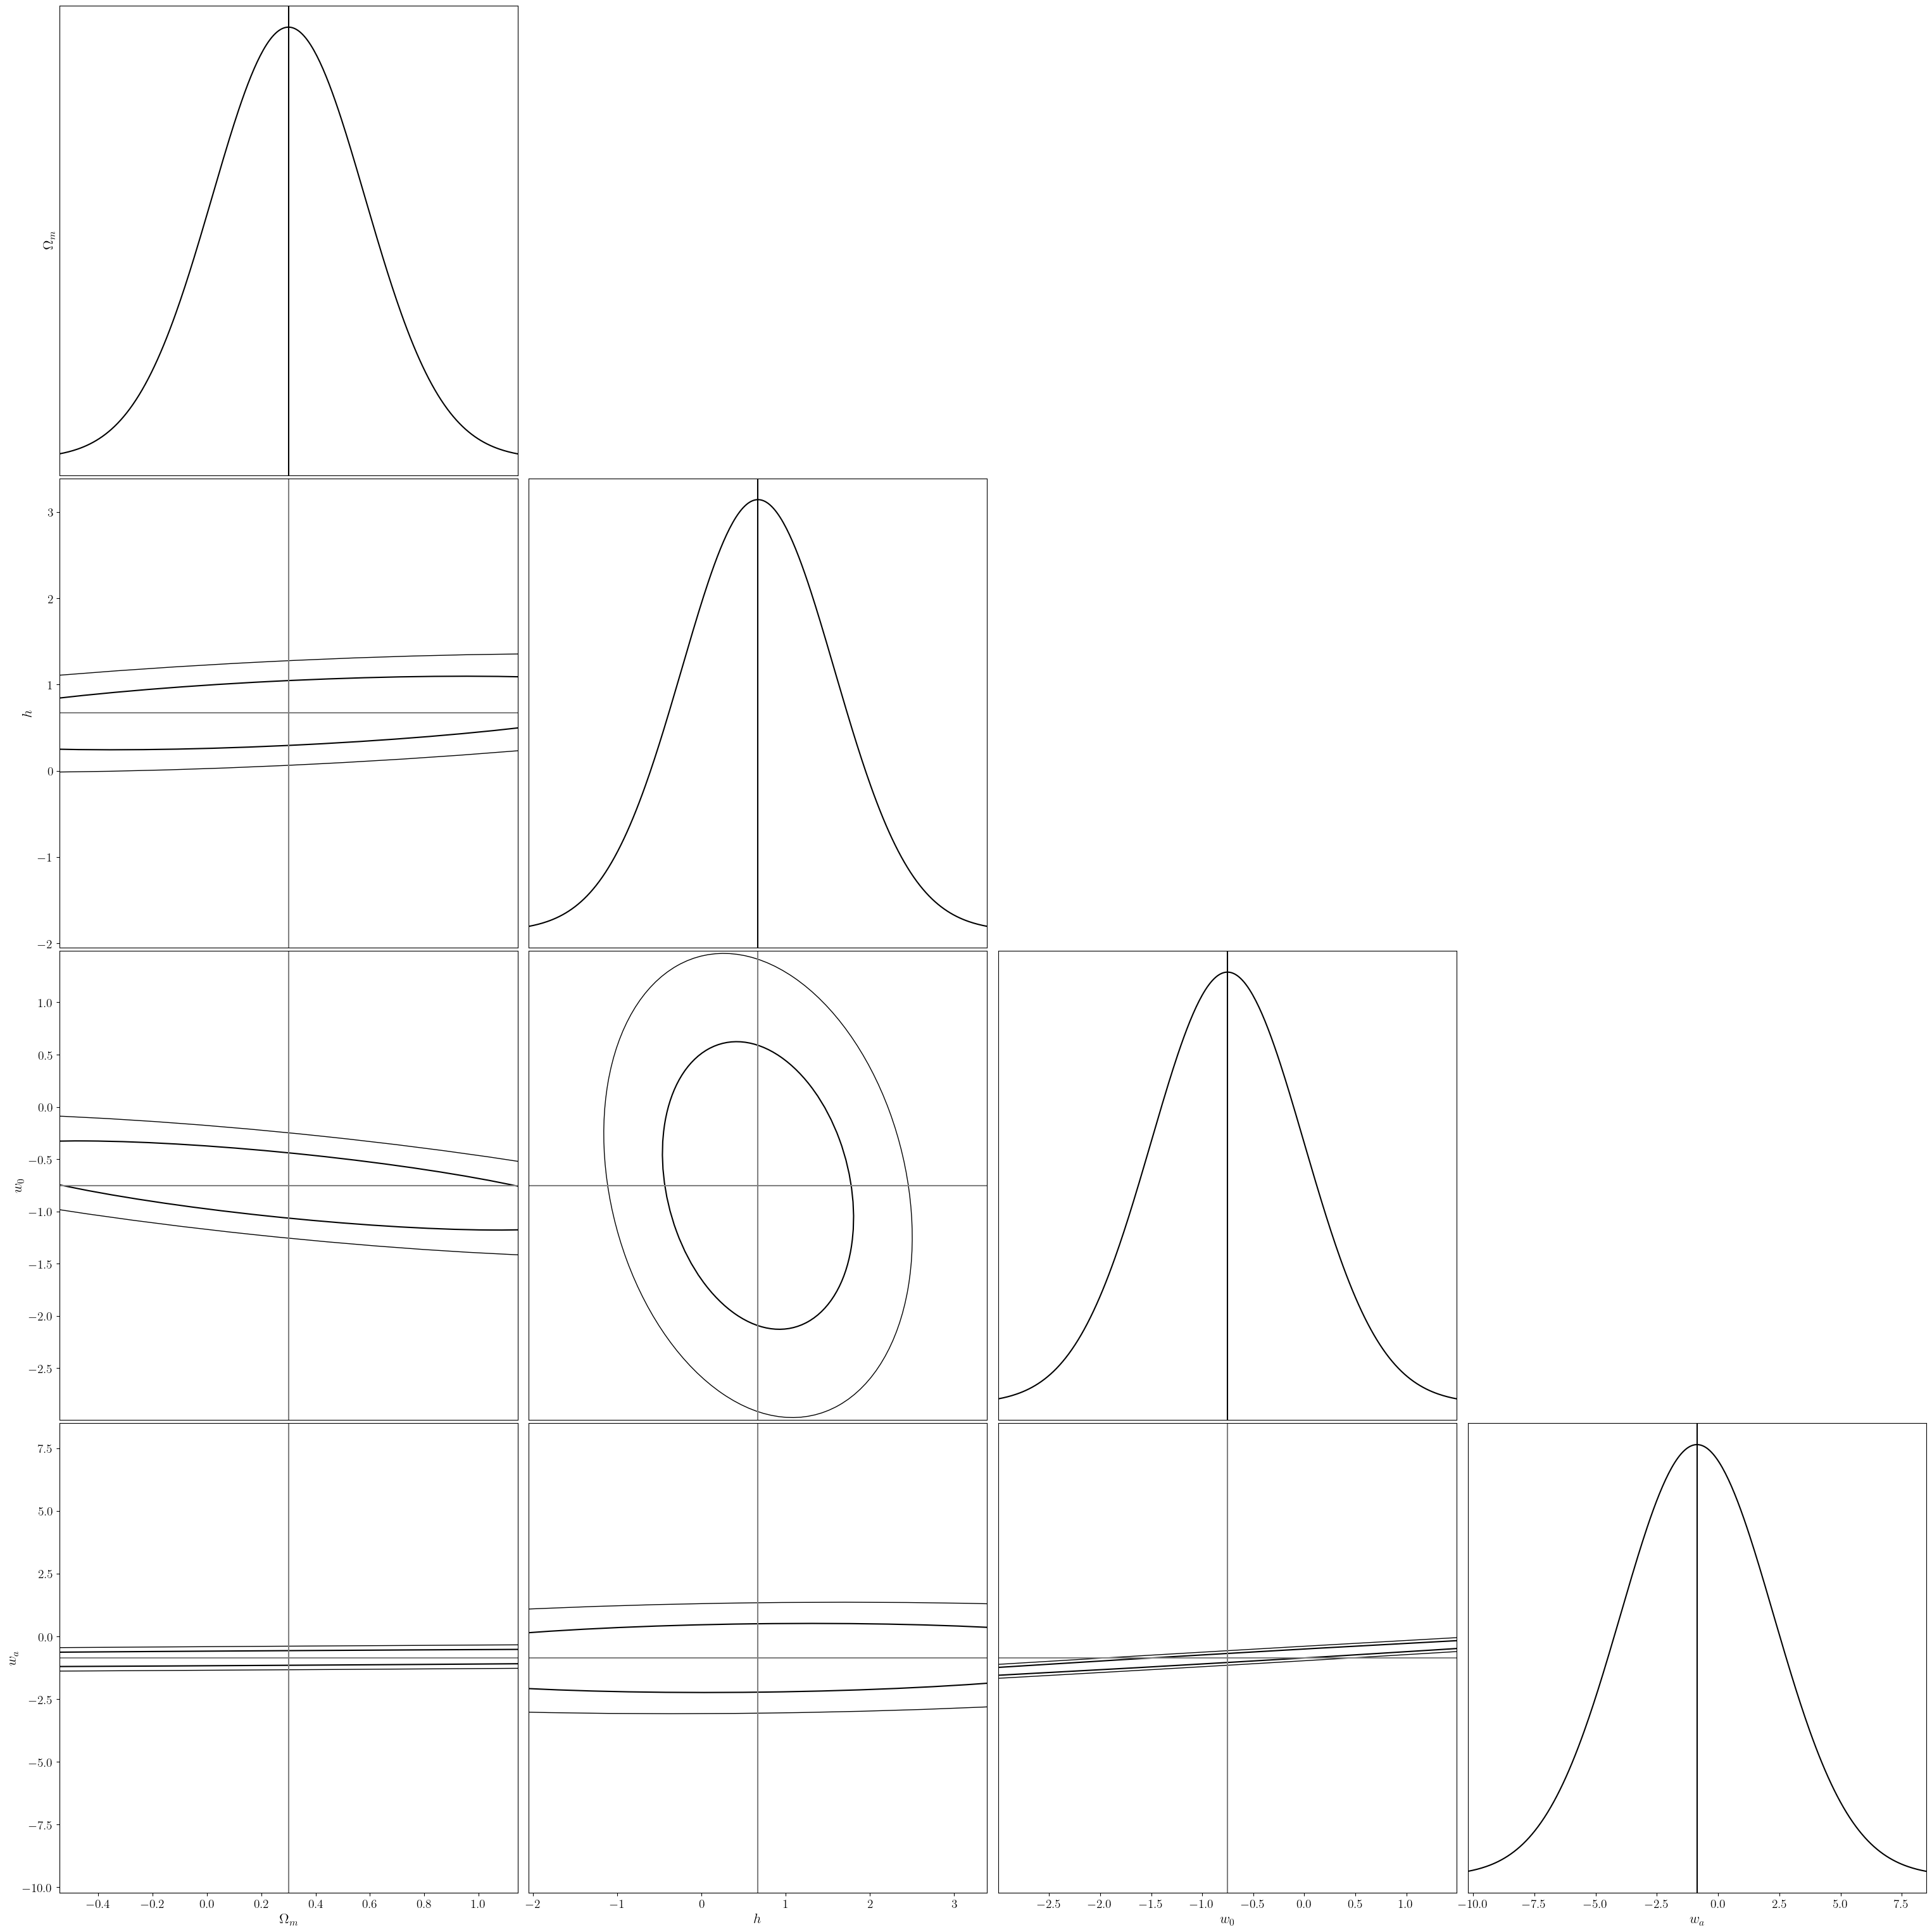

In [23]:
forecast.plot_fisher_ellipses(Fisher, param_list, truths={p: fid_cosmo[p] for p in param_list})

# plot the difference

In [24]:
def plot_shear_ratio_differences(forecast, cl_dict, gk_labels, R_cov, w0_vals=[-1.0, -0.5], color_cycle=None):
    """
    Plot the difference between the shear ratio data vector and the fiducial model.

    Parameters
    ----------
    forecast : Forecast3x2pt
        Initialized forecast object.
    cl_dict : dict
        Fiducial Cl dictionary.
    gk_labels : list
        Labels from extract_gk_vector().
    R_cov : np.ndarray
        Shear ratio covariance matrix.
    w0_vals : list
        Values of w0 to compare (excluding fiducial).
    color_cycle : list or None
        Optional list of matplotlib colors.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    R_err = np.sqrt(np.diag(R_cov))
    fid_backup = forecast.fid_cosmo.copy()
    w0_fid = fid_backup["w0"]

    if color_cycle is None:
        color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    plt.figure(figsize=(12, 6))

    # Compute fiducial model
    forecast.fid_cosmo = fid_backup.copy()
    forecast._init_cosmology()
    gk_vec_fid, _ = forecast.extract_gk_vector(cl_dict)
    R_fid, ratio_labels = forecast.compute_shear_ratios(gk_vec_fid, gk_labels)

    x = np.arange(len(R_fid))

    # Plot zero line
    plt.axhline(0, color='black')

    # Error bars centered at 0
    plt.errorbar(x, np.zeros_like(x), yerr=R_err, fmt='o', color='black',
                 label=f"Fiducial (w0 = {w0_fid})", capsize=3)

    # Differences
    for idx, w0 in enumerate(w0_vals):
        forecast.fid_cosmo = fid_backup.copy()
        forecast.fid_cosmo["w0"] = w0
        forecast._init_cosmology()
        cl_new = forecast.compute_cls()
        gk_vec_new, _ = forecast.extract_gk_vector(cl_new)
        R_new, _ = forecast.compute_shear_ratios(gk_vec_new, gk_labels)
        diff = R_new[:, 0] - R_fid[:, 0]
        plt.scatter(x, diff, label=f"w0 = {w0}", color=color_cycle[idx % len(color_cycle)])

    # Restore
    forecast.fid_cosmo = fid_backup.copy()
    forecast._init_cosmology()

    xlabels = [f"g{i}/k{j},{k}" for (i, j, k) in ratio_labels]
    plt.xticks(x, xlabels, rotation=90, fontsize=5)
    plt.ylabel("Shear Ratio Difference")
    plt.title("Difference from Fiducial Shear Ratio")
    plt.legend()
    plt.tight_layout()
    plt.show()


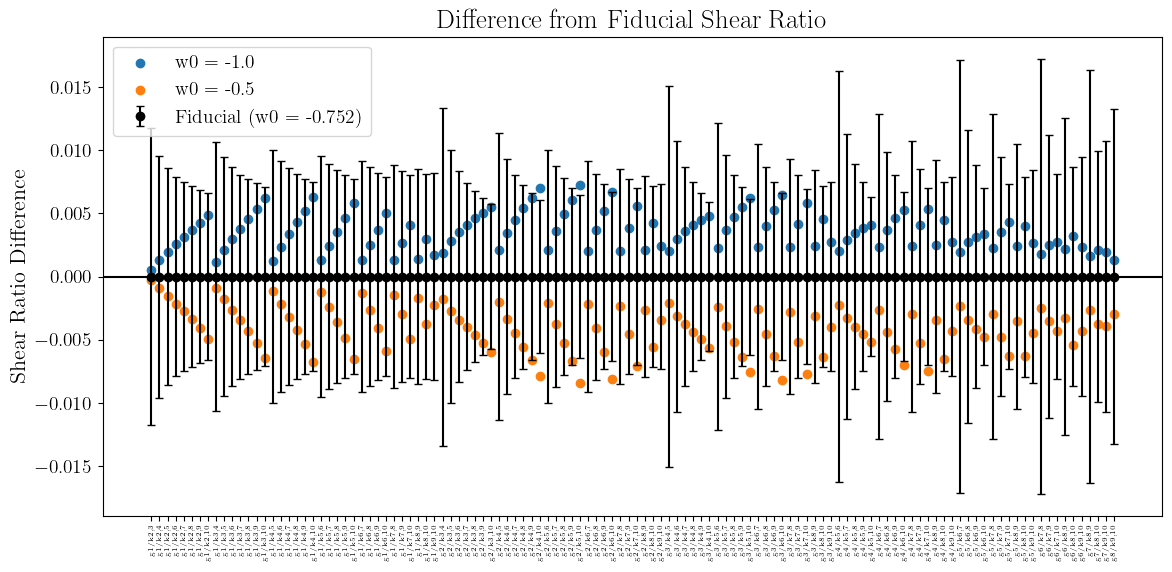

In [25]:
plot_shear_ratio_differences(forecast, cl_dict, gk_labels, R_cov, w0_vals=[-1.0, -0.5])

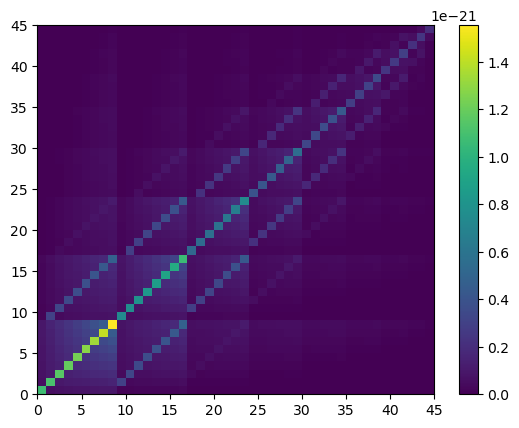

In [10]:
plt.pcolormesh(cov_gk)
plt.colorbar()